In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random
import numpy as np
from torch.nn import Module

class CustomTrainDataset1(Dataset,Module):
    def __init__(self, folder_path, index_array, transform=None):
        self.folder_path = folder_path
        self.image_paths=[os.path.join(folder_path,file) for file in os.listdir(folder_path) if file.lower().endswith(('.jpg', '.jpeg'))]
        self.label = index_array
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)  # 이미지 파일의 이름을 가져오기
        image = Image.open(image_path).convert('RGB')  # 이미지를 열고 RGB 형식으로 변환
        if self.transform:
            image = self.transform(image)
        return image,self.label

# 이미지 전처리를 위한 변환기 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조절
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])


In [2]:
# DataLoader를 사용하여 배치로 나누기
batch_size = 10

In [3]:
#라벨 정보
LABELS={'김성아':0,
        '김성원':1,
        '아이유':2}

datasets=[]

for label_name,label in LABELS.items():
  folder_path1=f'/content/drive/MyDrive/{label_name}'
  # CustomDataset 객체 생성
  datasets.append(CustomTrainDataset1(folder_path1, label, transform=transform))


In [4]:
train_loader = DataLoader(torch.utils.data.ConcatDataset(datasets), batch_size=batch_size, shuffle=True,num_workers=8)

In [5]:
len(train_loader.dataset)

64

In [ ]:
class CustomTestDataset(Dataset,Module):
    def __init__(self, folder_path, index_array, transform=None):
        self.folder_path = folder_path
        #image_files=[os.path.join(folder_path,file) for file in os.listdir(folder_path)]
        #self.image_paths=random.sample(image_files,1000)
        self.image_paths = [os.path.join(folder_path, img) for img in os.listdir(folder_path) if img.endswith('.jpg')]
        self.label = index_array
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = os.path.basename(image_path)  # 이미지 파일의 이름을 가져오기
        image = Image.open(image_path).convert('RGB')  # 이미지를 열고 RGB 형식으로 변환
        if self.transform:
            image = self.transform(image)
        return image,self.label

# 이미지 전처리를 위한 변환기 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조절
    transforms.ToTensor(),           # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])


In [ ]:
LABELS={'기쁨':0,
        '당황':1,
        '분노':2,
        '불안':3,
        '슬픔':4,
        '중립':5}

datasets=[]

for label_name,label in LABELS.items():
  folder_path=f'/content/drive/MyDrive/종설/test/{label_name}'

  # CustomDataset 객체 생성
  datasets.append(CustomTestDataset(folder_path, label, transform=transform))



In [ ]:
test_loader = DataLoader(torch.utils.data.ConcatDataset(datasets), batch_size=batch_size, shuffle=True,num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
import torchvision.transforms as transforms
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union
import torch
import torch.nn as nn
from torch import Tensor
from torch.optim.lr_scheduler import StepLR

In [7]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [8]:
class BasicBlock(nn.Module):
    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        #dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()

        # Normalization Layer
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        #self.relu = nn.LeakyReLU(0.1)
        self.relu=nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # downsampling이 필요한 경우 downsample layer를 block에 인자로 넣어주어야함
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # residual connection
        out = self.relu(out)

        return out

In [9]:
class ResNet(nn.Module):
    def __init__(
        self,
        block: BasicBlock,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer  # batch norm layer

        self.inplanes = 64  # input shape
        #self.dilation = 1  # dilation fixed
        self.groups = 1  # groups fixed

        # input block
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        #self.relu =nn.LeakyReLU(0.1)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # residual blocks
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)


        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: BasicBlock, planes: int, blocks: int,
                    stride: int = 1) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None

        # downsampling 필요할경우 downsample layer 생성
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes, stride),
                norm_layer(planes),
            )

        layers = []
        #layers.append(block(self.inplanes, planes, stride, downsample, self.groups,self.dilation, norm_layer))
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            norm_layer))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        print("forward")
        #print('input shape:', x.shape)
        x = self.conv1(x)
        #print('conv1 shape:', x.shape)
        x = self.bn1(x)
        #print('bn1 shape:', x.shape)
        x = self.relu(x)
        #print('relu shape:', x.shape)
        x = self.maxpool(x)
        #print('maxpool shape:', x.shape)

        x = self.layer1(x)
        #print('layer1 shape:', x.shape)
        x = self.layer2(x)
        #print('layer2 shape:', x.shape)
        x = self.layer3(x)
        #print('layer3 shape:', x.shape)
        x = self.layer4(x)
        #print('layer4 shape:', x.shape)

        x = self.avgpool(x)
        #print('avgpool shape:', x.shape)
        x = torch.flatten(x, 1)
        #print('flatten shape:', x.shape)
        x = self.fc(x)
        #print('fc shape:', x.shape)

        return x


In [10]:

# ResNet-50 모델 정의
model = ResNet(BasicBlock,[2,2,2,2],num_classes=3,zero_init_residual=True)

# 손실 함수 및 옵티마이저 설정
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [16]:
# 모델 학습
num_epochs = 50
# 에폭을 반복하면서 학습과 검증을 수행
for epoch in range(num_epochs):
    '''
    checkpoint = torch.load('/content/drive/MyDrive/Resnet(3,4,8,3)_checkpoint_epoch{}.pt'.format(epoch))
    # 모델과 옵티마이저의 상태 복원
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    '''
    i=0
    # 학습 단계
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()
        print(f'epoch: {epoch}, batch: {i}')
        i+=1



    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }

    # 저장 경로 설정
    if epoch==49:
        save_path = '/content/drive/My Drive/model_checkpoint_epoch{}.pt'.format(epoch)

        # 딕셔너리를 파일로 저장
        torch.save(checkpoint, save_path)

    #model.train()  # 모델을 학습 모드로 전환



forward
epoch: 0, batch: 0
forward
epoch: 0, batch: 1
forward
epoch: 0, batch: 2
forward
epoch: 0, batch: 3
forward
epoch: 0, batch: 4
forward
epoch: 0, batch: 5
forward
epoch: 0, batch: 6
forward
epoch: 1, batch: 0
forward
epoch: 1, batch: 1
forward
epoch: 1, batch: 2
forward
epoch: 1, batch: 3
forward
epoch: 1, batch: 4
forward
epoch: 1, batch: 5
forward
epoch: 1, batch: 6
forward
epoch: 2, batch: 0
forward
epoch: 2, batch: 1
forward
epoch: 2, batch: 2
forward
epoch: 2, batch: 3
forward
epoch: 2, batch: 4
forward
epoch: 2, batch: 5
forward
epoch: 2, batch: 6
forward
epoch: 3, batch: 0
forward
epoch: 3, batch: 1
forward
epoch: 3, batch: 2
forward
epoch: 3, batch: 3
forward
epoch: 3, batch: 4
forward
epoch: 3, batch: 5
forward
epoch: 3, batch: 6
forward
epoch: 4, batch: 0
forward
epoch: 4, batch: 1
forward
epoch: 4, batch: 2
forward
epoch: 4, batch: 3
forward
epoch: 4, batch: 4
forward
epoch: 4, batch: 5
forward
epoch: 4, batch: 6
forward
epoch: 5, batch: 0
forward
epoch: 5, batch: 1
f

In [ ]:
saved_epoch=0
checkpoint = torch.load('/content/drive/My Drive/model_checkpoint_epoch{}.pt'.format(saved_epoch))
# 모델과 옵티마이저의 상태 복원
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#accuracy = checkpoint['Accuracy']
print(accuracy)

75.78


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


checkpoint = torch.load('/content/drive/MyDrive/Resnet_checkpoint_epoch9.pt')
# 모델과 옵티마이저의 상태 복원
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
emotion={0:'pleasure',
        1:'embarrassed',
        2:'angry',
        3:'anxious',
        4:'sad',
        5:'neutral'}
softmax=nn.Softmax(dim=0)

model.eval()  # 모델을 평가 모드로 전환
val_loss = 0.0
correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for test_inputs, test_targets in test_loader:

      test_outputs = model(test_inputs)
      #print(test_outputs)
      # 이미지와 예측값을 시각화
      for i in range(test_inputs.size(0)):
        image = test_inputs[i].permute(1, 2, 0).numpy()  # 이미지 텐서를 NumPy 배열로 변환 (H, W, C 순서로 변환)
        prediction = test_outputs[i].argmax().item()  # 예측 결과 중 가장 높은 확률을 갖는 클래스의 인덱스
        # 이미지 출력
        plt.imshow(image)
        p=emotion[prediction]
        plt.title("Predicted Class: "+p)
        plt.show()

        softmax_values = softmax(test_outputs[i])
        # 출력값을 소수점 두 자리까지만 표시
        formatted_softmax_values = ["{:.2f}".format(value) for value in softmax_values]

        # 주어진 감정 클래스 라벨
        emotion_labels = ['pleasure', 'embarrassed', 'angry', 'anxious', 'sad', 'neutral']
        # 막대 그래프 생성
        plt.figure(figsize=(5, 5))
        plt.bar(emotion_labels, softmax_values, color='blue')
        plt.xlabel('Emotion Classes')
        plt.ylabel('Softmax Probabilities')
        plt.title('Softmax Probabilities for Emotion Classes')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


NameError: ignored

forward


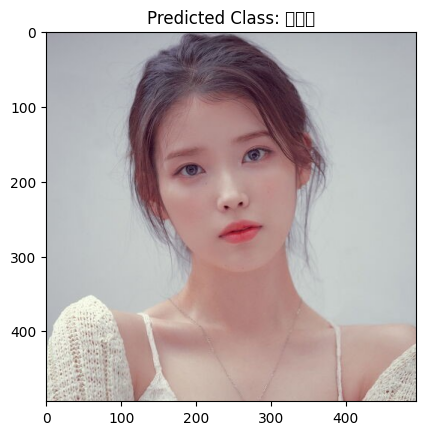

tensor([[-0.3714,  0.5395, -1.5010]])
[0.26248660683631897, 0.6526841521263123, 0.08482927083969116]


<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 44608 (\N{HANGUL SYLLABLE GIM}) missing from current font.
  plt.tight_layout()
<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  plt.tight_layout()
<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  plt.tight_layout()
<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  plt.tight_layout()
<ipython-input-17-0f6537071a28>:66: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  plt.tight_layout()


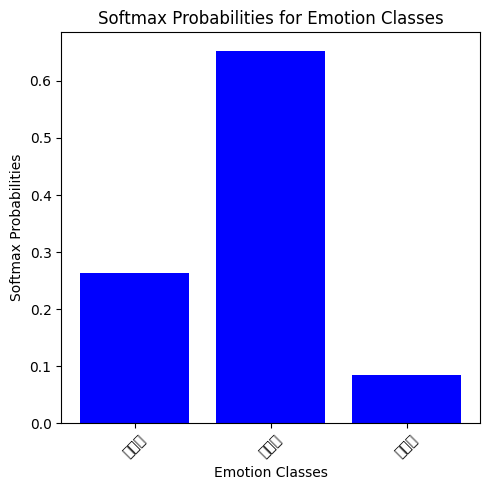

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지가 있는 폴더 경로
folder_path = '/content/drive/MyDrive/종설/small_test1'

# 폴더 내의 파일 목록 가져오기
file_list = os.listdir(folder_path)
# 주어진 감정 클래스 라벨
emotion_labels = ['김성아', '김성원', '아이유']
checkpoint = torch.load('/content/drive/My Drive/model_checkpoint_epoch9.pt')
# 모델과 옵티마이저의 상태 복원
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
emotion={0:'김성아',
        1:'김성원',
        2:'아이유'}
softmax=nn.Softmax(dim=0)

model.eval()  # 모델을 평가 모드로 전환
val_loss = 0.0
correct_predictions = 0
total_samples = 0

# 이미지 파일들을 하나씩 처리
for file_name in file_list:
    # 이미지 파일 경로 생성
    file_path = os.path.join(folder_path, file_name)

    # 이미지 열기
    image = Image.open(file_path)

    # 이미지 변환
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = transform(image).unsqueeze(0)  # 배치 차원 추가

    # 모델 예측
    with torch.no_grad():
        output = model(input_tensor)

    # 예측된 클래스 인덱스
    prediction = output.argmax().item()
    predicted_emotion = emotion[prediction]

    # 이미지 출력
    plt.imshow(image)
    plt.title("Predicted Class: " + predicted_emotion)
    plt.show()

    # 소프트맥스 확률 계산
    print(output)
    softmax_values = softmax(output[0])
    softmax_values = softmax_values.squeeze().tolist()
    print(softmax_values)
    # 막대 그래프 생성
    plt.figure(figsize=(5, 5))
    plt.bar(emotion_labels, softmax_values, color='blue')
    plt.xlabel('Emotion Classes')
    plt.ylabel('Softmax Probabilities')
    plt.title('Softmax Probabilities for Emotion Classes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

